In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
!pip install imutils

import tensorflow
from PIL import Image
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, save_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization,Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation,GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

import numpy as np 
from tqdm import tqdm
from sklearn.utils import shuffle
import cv2
import os
import shutil
import itertools
import imutils
from sklearn.model_selection import StratifiedKFold
import random
from tensorflow.keras import layers

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25861 sha256=cb85cfac5489d6f838c8b3a0f257172ee5b937c69b7526b436a6f1b3f9300af6
  Stored in directory: /root/.cache/pip/wheels/35/e4/69/cb99d996d14a2971b79b990d68b05a17d58ce530ff96090dfc
Successfully built imutils


In [4]:
#KERAS LIB FOR CNN
import keras
from keras.models import Sequential
from keras.layers import Conv2D,Flatten,Dense,MaxPooling2D,Dropout
from sklearn.metrics import accuracy_score

#lIBRARIES
import ipywidgets as widgets
import io
from PIL import Image
import tqdm
from sklearn.model_selection import train_test_split
import cv2
from sklearn.utils import shuffle
import tensorflow as tf

Folder join

In [5]:
X_train = []
Y_train = []
image_size = 200
labels = ['glioma_tumor','meningioma_tumor','no_tumor','pituitary_tumor']
for i in labels:
    folderPath = os.path.join('/kaggle/input/braintumor-augmented/Imagedataset/Training',i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        Y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('/kaggle/input/braintumor-augmented/Imagedataset/Testing',i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        Y_train.append(i)

X_train = np.array(X_train)
Y_train = np.array(Y_train)

In [6]:
X_train,Y_train = shuffle(X_train,Y_train,random_state=101)
X_train.shape

(15264, 200, 200, 3)

Train TEST SPLIT

In [7]:
X_train,X_test,y_train,y_test = train_test_split(X_train,Y_train,test_size=0.2,random_state=101)

In [8]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train=y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test=y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

CNN

In [9]:

from tensorflow.keras.applications.resnet import ResNet50
IMG_SIZE=(200,200)
conv_base = ResNet50(
    include_top=False,
    input_shape=IMG_SIZE + (3,),
    weights='imagenet')

for layer in conv_base.layers:
    layer.trainable = True
    
model = conv_base.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.4)(model)
model = Dense(4, activation="softmax")(model)
model = Model(inputs= conv_base.input, outputs= model)

#compile our model.
adam = Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics=['accuracy'])
model.summary()



94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

In [10]:
callbacks = [ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss',mode='min',verbose=1, save_best_only=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1, mode='min', min_lr=0.00000000001)]

In [11]:
train_len = len(X_train)
val_len = len(X_test)
print("-----------Training Data length-----------------")
print(train_len)

print("-----------Validation Data length-----------------")
print(val_len)

-----------Training Data length-----------------
12211
-----------Validation Data length-----------------
3053


In [12]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),batch_size=64, epochs=15, callbacks=callbacks)


Epoch 1/15
191/191 [==============================] - ETA: 0s - loss: 0.2827 - accuracy: 0.8984
Epoch 1: val_loss improved from inf to 0.29722, saving model to .mdl_wts.hdf5
191/191 [==============================] - 102s 323ms/step - loss: 0.2827 - accuracy: 0.8984 - val_loss: 0.2972 - val_accuracy: 0.9227 - lr: 1.0000e-04
Epoch 2/15
191/191 [==============================] - ETA: 0s - loss: 0.0412 - accuracy: 0.9869
Epoch 2: val_loss improved from 0.29722 to 0.20324, saving model to .mdl_wts.hdf5
191/191 [==============================] - 60s 312ms/step - loss: 0.0412 - accuracy: 0.9869 - val_loss: 0.2032 - val_accuracy: 0.9378 - lr: 1.0000e-04
Epoch 3/15
191/191 [==============================] - ETA: 0s - loss: 0.0318 - accuracy: 0.9894
Epoch 3: val_loss did not improve from 0.20324
191/191 [==============================] - 58s 306ms/step - loss: 0.0318 - accuracy: 0.9894 - val_loss: 0.9067 - val_accuracy: 0.8356 - lr: 1.0000e-04
Epoch 4/15
191/191 [==============================]

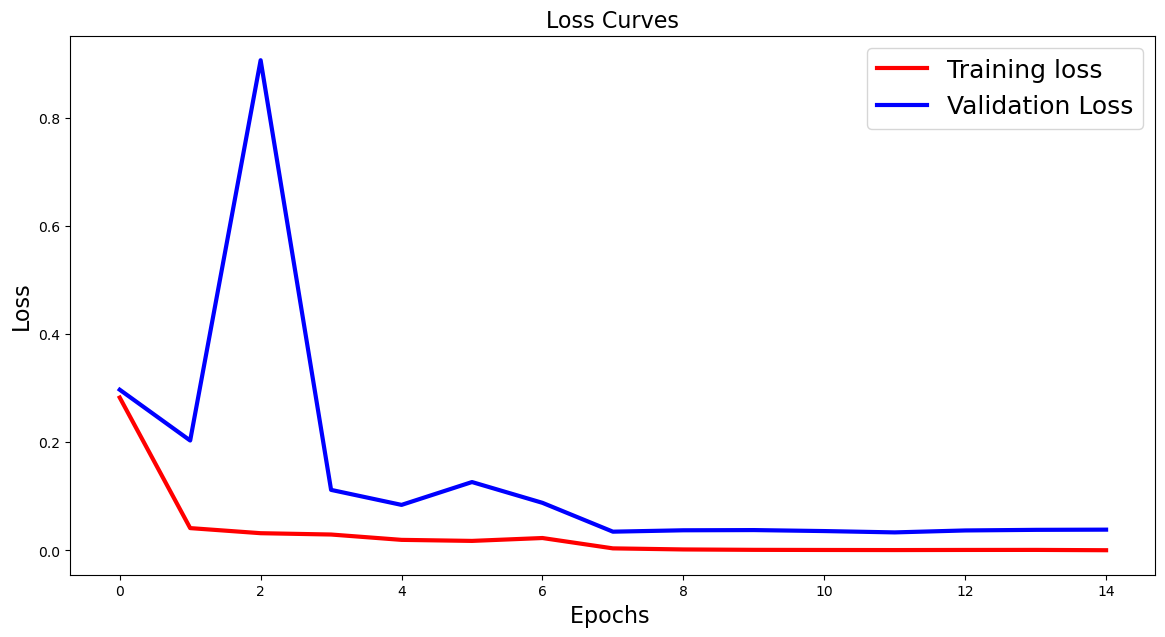

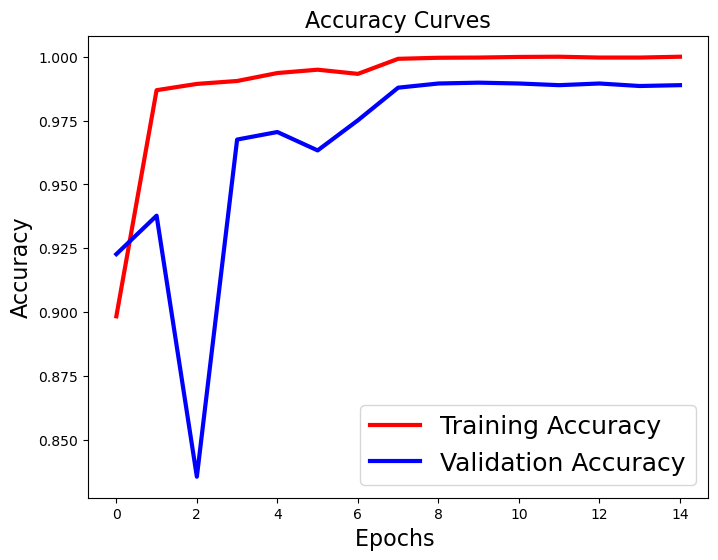

In [13]:
#Plot the Loss Curves
plt.figure(figsize=[14,7])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.show()

#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)   
plt.show()

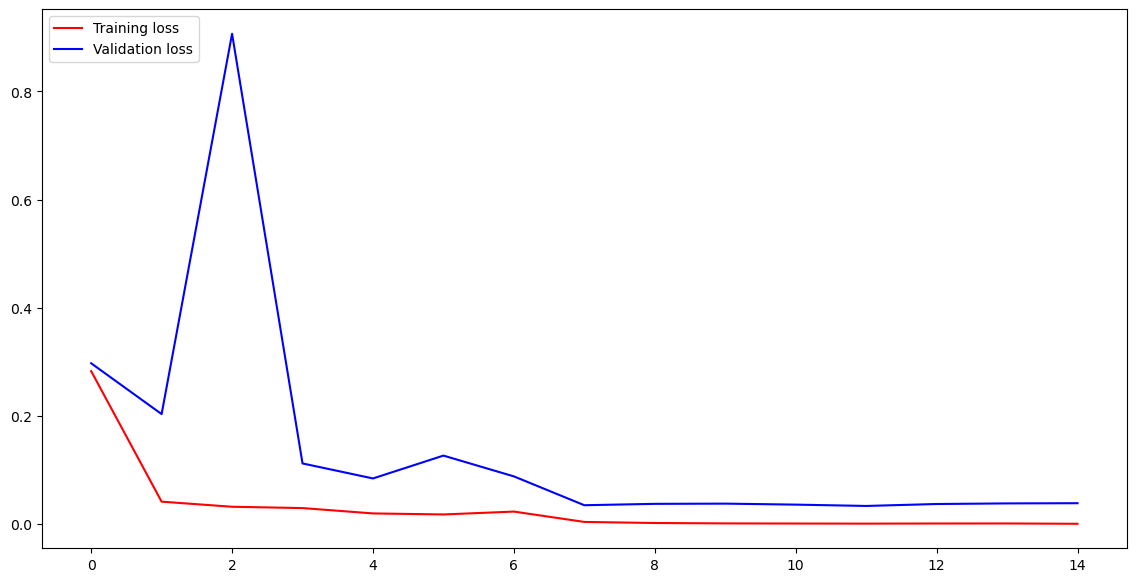

96/96 [==============================] - 5s 53ms/step - loss: 0.0384 - accuracy: 0.9889


In [14]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
fig = plt.figure(figsize=(14,7))
plt.plot(epochs,loss,'r',label="Training loss")
plt.plot(epochs,val_loss,'b',label="Validation loss")
plt.legend(loc='upper left')
plt.show()
loss,acc = model.evaluate(X_test,y_test)
import matplotlib.pyplot as plt
import seaborn as sns
model.save('braintumor.h5')


In [15]:
img = cv2.imread('/kaggle/input/braintumor-augmented/Imagedataset/Training/pituitary_tumor/p (103).jpg')
img = cv2.resize(img,(200,200))
img_array = np.array(img)
img_array.shape
import seaborn as sns
predicted_classes = np.argmax(model.predict(X_test), axis = 1)
print(classification_report(np.argmax(y_test,axis=1), predicted_classes,target_names=['glioma','meningioma','no_tumor','pituitary']))

96/96 [==============================] - 5s 45ms/step
              precision    recall  f1-score   support

      glioma       0.99      0.98      0.99       765
  meningioma       0.98      0.98      0.98       791
    no_tumor       1.00      1.00      1.00       724
   pituitary       0.99      1.00      0.99       773

    accuracy                           0.99      3053
   macro avg       0.99      0.99      0.99      3053
weighted avg       0.99      0.99      0.99      3053



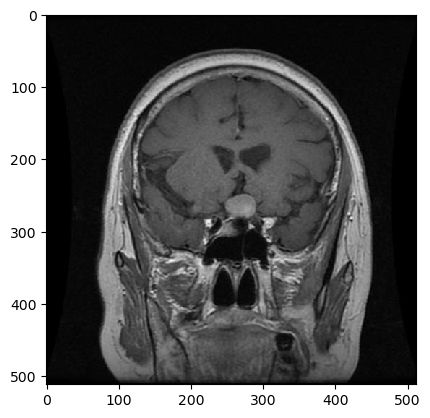

1/1 [==============================] - 0s 137ms/step


3

In [16]:
img_array = img_array.reshape(1,200,200,3)
img_array.shape
from tensorflow.keras.preprocessing import image
img = image.load_img('/kaggle/input/braintumor-augmented/Imagedataset/Training/pituitary_tumor/p (103).jpg')
plt.imshow(img,interpolation='nearest')
plt.show()
a=model.predict(img_array)
indices = a.argmax()
indices

Converting base saved model h5 to tflite for deployment

In [17]:
model = tf.keras.models.load_model('braintumor.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("braintumor.tflite", "wb").write(tflite_model)
new_model = tf.keras.models.load_model('/kaggle/working/braintumor.h5')
new_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              